In [155]:
## missions make least 5% of the data outlier 2:07

# Imports

In [156]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import re
import pandas as pd
from lxml import etree 
#import matplotlib.pyplot as plt
from selenium.webdriver.common.action_chains import ActionChains
import time
from selenium.webdriver.common.keys import Keys
import math
import pandas as pd
import numpy as np
import datetime

# Methods

In [157]:
def extract_numbers(text):
  """Extracts numbers from the given text."""
  numbers = re.search(r'\d+(\.\d*)?K?', text)
  try:
    likes=float(numbers.group().split('K')[0])
    if 'K' in numbers.group():
        likes*=1000
    return likes
  except:
    pass

In [158]:
def delete_days(date):
    """ Convert Date from YY-MM-DD to a single integer
        ,We  will consider we took post from 2015 and after
        Each 4 months will be converted into one value
    """
    text=str(date)
    text=text.split('-')
    return text[0]+'-'+text[1]

In [159]:
def convert_date(date):
    """ Convert Date from YY-MM-DD to a single integer
        ,We  will consider we took post from 2015 and after
        Each 4 months will be converted into one value
    """
    text=str(date)
    text=text.split('-')
    year=int(text[0])-2015
    ## we will consider each 2 months as plus one 
    
    month=int(int(text[1])/2)

    ## 2015-1-1 = {1} , 2015-3-1 = {2} , 2015-5-1 = {3} , 2015-7-1 = {4} , 2016-1-1 = {7} .....
    date=year*6 + month
    
    return date

In [160]:

def find_outliers_IQR(df):
    '''
    Find outlier in the Data
    '''
    q1=df.quantile(0.3)

    q3=df.quantile(0.7)

    IQR=q3-q1
    print('low: ',q1-1.5*IQR)
    print('high: ',q3+1.5*IQR)

    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers
def find_upper_outliers_IQR(df):
    '''check if the outlier is too high'''
    q1=df.quantile(0.3)

    q3=df.quantile(0.7)

    IQR=q3-q1
    outliers = df[(df>(q3+1.5*IQR))]
    return outliers
def find_lower_outliers_IQR(df):
    '''check if the outlier is too low'''
    q1=df.quantile(0.3)

    q3=df.quantile(0.7)

    IQR=q3-q1
    outliers = df[(df<(q1-1.5*IQR))]
    return outliers

In [161]:
def trnsfrm_1_10 (months_3,current):
    ''' Transform likes and comments from a real number to rating from 1 to 10'''
    mini=np.min(months_3)
    maxi=np.max(months_3)
    b = np.ndarray.round((current-mini)/(maxi-mini)*9+1)
    print(b.max())
    return b

# Main

In [162]:
df=pd.read_csv('Talha_Data.csv')

df.shape[0]

2349

## Extracitng Data 

In [163]:
## extracting numbers of likes
df['likes']=df['likes'].apply(extract_numbers)

nul=df['likes'].isnull().sum()
print('No of None: ',nul)

## Delete None values
df.dropna(subset=['likes'], inplace=True)
print('shape after droping: ',df.shape[0])

No of None:  14
shape after droping:  2335


In [164]:
df['comments']=df['comments'].apply(extract_numbers)

nul=df['comments'].isnull().sum()
print('No of None: ',nul)

## Delete None values
df.dropna(subset=['comments'], inplace=True)
print('shape after droping: ',df.shape[0])

No of None:  0
shape after droping:  2335


In [165]:
# converting dates, evry 2 months to single int number
df['date']=df['date'].apply(convert_date)
df['date'].unique()

array([56, 57, 43, 55, 42, 44, 45, 58], dtype=int64)

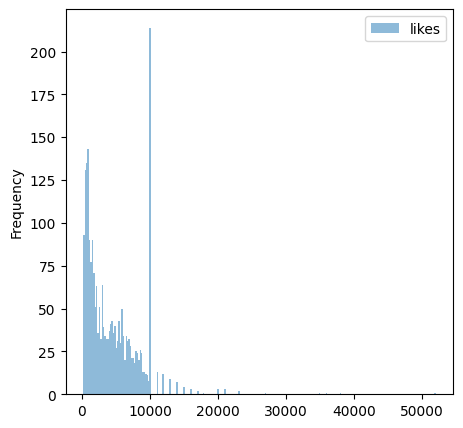

In [166]:
# ploting histogram of likes
## as we can see that it is not normaly distriputed
ax = df.plot.hist(column=["likes"], figsize=(5, 5),bins=250, alpha=0.5)

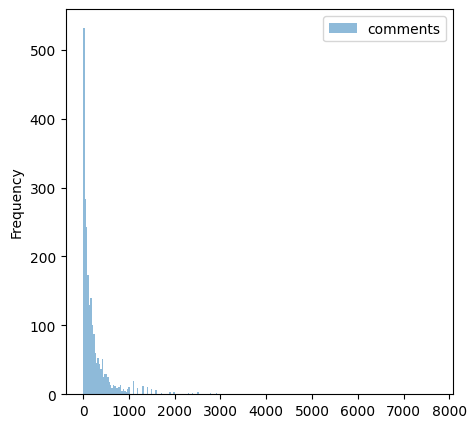

In [167]:
# ploting histogram of comments
## as we can see that it is not normaly distriputed
ax = df.plot.hist(column=["comments"], figsize=(5, 5),bins=250, alpha=0.5)

In [168]:
# checking for ouliers in likes
x=find_outliers_IQR(df[['likes']])
## Numper of rows has likes is an outlier
print('Likes outliers:' ,df.shape[0]-x.isnull().sum().iloc[0])
df['likes_outlier'] = np.where(np.isnan(x['likes']), 0, 1)


low:  likes   -5250.0
dtype: float64
high:  likes    12750.0
dtype: float64
Likes outliers: 39


In [169]:
# checking for ouliers in likes
x=find_outliers_IQR(df[['comments']])
## Numper of rows has likes is an outlier
print('comments outliers:' ,df.shape[0]-x.isnull().sum().iloc[0])
df['comments_outlier'] = np.where(np.isnan(x['comments']), 0, 1)


low:  comments   -225.7
dtype: float64
high:  comments    501.5
dtype: float64
comments outliers: 295


In [170]:
df['comments'].min()

1.0

In [171]:
# making all likes upper outliers rate to be 20/10 "too good"

upper_outlier=find_upper_outliers_IQR(df[['likes']])
df['likes_rate'] = df['likes'].where(np.isnan(upper_outlier['likes']),11)



# note: upper oulier means the value is a high outlier and the same for lowe outlier 
df[df['likes_rate']==20].shape

(0, 9)

In [172]:
# making all likes lower outliers rate to be -10/10 "too low"
## scince lower outlier boundry is negative, so we will force least 5% of the data to be an outlier
### to not overwrite the previous upper outlier , we keep the likes rate as it is for all instead for lower outlier

# geting value of 5% of the shape
five_percent=int(0.05*df.shape[0])
# sorting data based on likes, then getting the value of likes on the 5% row
five_percent_max_comments=df.sort_values('likes').iloc[five_percent]['likes']
# getting all least 5% rows
lower_outlier=df[df['likes']<=five_percent_max_comments]

# checking if the data exceeded 5% => reduce the likes value by 1.
if((lower_outlier.shape[0]/df.shape[0]) >0.06):
        five_percent_max_comments-=1
df.loc[df['likes']<=five_percent_max_comments,'likes_rate']=0
df.loc[df['likes']<=five_percent_max_comments,'likes_outlier']=1
print('lower outlier percent: ',lower_outlier.shape[0]/df.shape[0])


lower outlier percent:  0.050107066381156314


In [173]:
df[df['likes_rate']==-10].shape[0]

0

In [174]:
# repeating steps for comments
# making all comments upper outliers rate to be 20/10 "too good"

upper_outlier=find_upper_outliers_IQR(df[['comments']])
df['comments_rate'] = df['comments'].where(np.isnan(upper_outlier['comments']),11)
print(df[df['comments_rate']==20].shape[0])


# note: upper oulier means the value is a high outlier and the same for lowe outlier 
df[df['comments_rate']==20].shape[0] +df[df['comments_rate']!=20].shape[0]

7


2335

In [175]:

# geting value of 5% of the shape
five_percent=int(0.05*df.shape[0])
# sorting data based on comments, then getting the value of comments on the 5% row
five_percent_max_comments=df.sort_values('comments').iloc[five_percent]['comments']
# getting all least 5% rows
lower_outlier=df[df['comments']<=five_percent_max_comments]

# checking if the data exceeded 5% => reduce the likes value by 1.
if((lower_outlier.shape[0]/df.shape[0]) >0.06):
        five_percent_max_comments-=1
df.loc[df['comments']<=five_percent_max_comments,'comments_rate']=0
df.loc[df['comments']<=five_percent_max_comments,'comments_outlier']=1

print('lower outlier percent: ',lower_outlier.shape[0]/df.shape[0])

lower outlier percent:  0.050107066381156314


In [176]:
df[df['comments_rate']==-10].shape[0]

0

In [177]:
x=df[df['likes_outlier']==0]
y=find_outliers_IQR(x['comments'])


low:  -206.5
high:  493.5


In [178]:
convert_date('2019-4-1')

26

In [179]:
## to scale likes from 1-10 we would get likes for 3 dates (6 months) and scale each (row likes) from 1-10 based on these 6 months


## getting only non outlier rows
g=df[df['likes_outlier']==0]
## itetrating over each date(2 months)
for i in g['date'].unique():
    
    ## to better estimate we calculate each month with the previous one and the after 
    months_3=g.loc[(g['date']==i) | (g['date']==i+1)|(g['date']==i-1)]
    current_month=g.loc[g['date']==i]
    
    ## applying scaling for likes to be 1-10
    likes_rate=trnsfrm_1_10(np.array(months_3['likes']),np.array(current_month['likes']))
    
    df.loc[(df['date']==i) & (df['likes_outlier']==0),'likes_rate']=likes_rate
    print(likes_rate.mean())

10.0
2.284375
5.0
1.659942363112392
10.0
5.287037037037037
8.0
2.3780487804878048
10.0
4.773584905660377
10.0
5.078703703703703
10.0
5.2227602905569
6.0
2.2549019607843137


In [180]:
## to scale comments from 1-10 we would get commments for 3 dates (6 months) and scale each (row commments) from 1-10 based on these 6 months

## getting only non outlier rows
g=df[df['comments_outlier']==0]
## itetrating over each date(2 months)

for i in g['date'].unique():
    
    ## to better estimate we calculate each month with the previous one and the after 
    months_3=g.loc[(g['date']==i) | (g['date']==i+1)|(g['date']==i-1)]
    current_month=g.loc[g['date']==i]
    
    ## applying scaling for commments to be 1-10
    comments_rates=trnsfrm_1_10(np.array(months_3['comments']),np.array(current_month['comments']))
    
    df.loc[(df['date']==i) & (df['comments_outlier']==0),'comments_rate']=comments_rates
    print(comments_rates.mean())


10.0
2.6136363636363638
9.0
2.1350574712643677
10.0
4.138028169014085
9.0
2.2027027027027026
10.0
3.8065693430656933
10.0
3.9885714285714284
10.0
4.163204747774481
10.0
2.3076923076923075


In [181]:
df[df['likes']<800].shape[0]/df.shape[0]

0.1468950749464668

In [182]:

df['comments_rate'].unique()

array([ 3.,  4., 11.,  0.,  1.,  2.,  9.,  5.,  6.,  8.,  7., 10.])

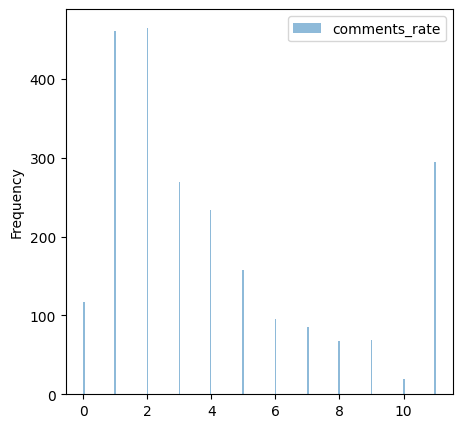

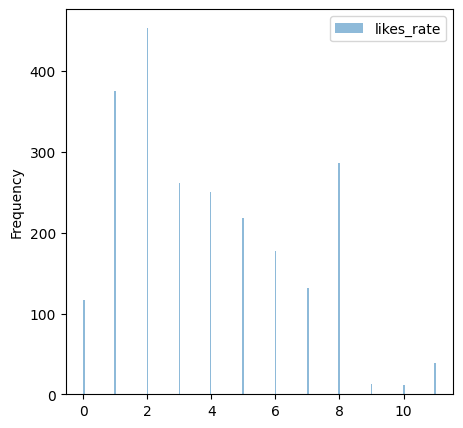

In [183]:

ax = df.plot.hist(column=["comments_rate"], figsize=(5, 5),bins=250, alpha=0.5)
ax = df.plot.hist(column=["likes_rate"], figsize=(5, 5),bins=250, alpha=0.5)

In [190]:
df['likes_rate'].value_counts()

likes_rate
1.0     1020
2.0      960
7.0      910
6.0      863
3.0      783
4.0      761
5.0      587
11.0     450
0.0      366
8.0      363
9.0       79
10.0      46
Name: count, dtype: int64

In [185]:
df.to_csv('Talha_Data_managed.csv',index=False)

In [186]:
df1=pd.read_csv('Awwad_Data_managed.csv')
df2=pd.read_csv('Derraji_Data_managed.csv')
df3=pd.read_csv('Talha_Data_managed.csv')
df=pd.concat([df1,df2,df3],axis=0)

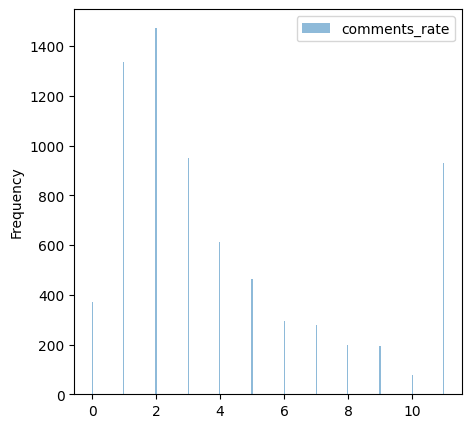

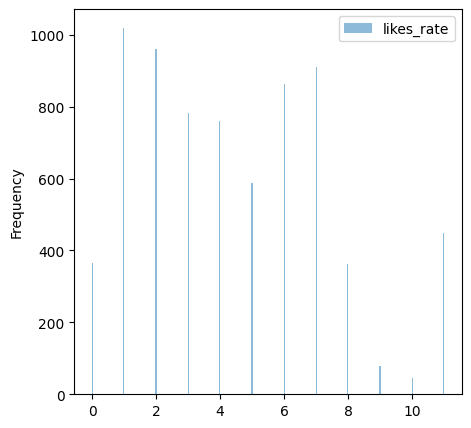